In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_curve,
    roc_auc_score, matthews_corrcoef, log_loss
)
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

def neural_networks(df):
    df['quality'] = df['quality'].apply(
        lambda q: 1.0 if q >= 7 else 0.0).astype(np.float32)
    X = df.drop('quality', axis=1)
    y = df['quality']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    cw = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train )
    class_weights = dict(enumerate(cw))

    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.001),
              input_shape=(X_train.shape[1],)),
        BatchNormalization(), Dropout(0.3),

        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(), Dropout(0.3),

        Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(), Dropout(0.2),

        Dense(1, activation='sigmoid')])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, 
                               restore_best_weights=True, verbose=1)
    reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                    patience=5, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=1,
        class_weight=class_weights)

    y_pred_probs = model.predict(X_test).ravel()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    optimal_idx      = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred_opt = (y_pred_probs >= optimal_threshold).astype(int)

    auc_value = roc_auc_score(y_test, y_pred_probs)
    mcc_value = matthews_corrcoef(y_test, y_pred_opt)
    ll_value  = log_loss(y_test, y_pred_probs)

    mcc_scores = [matthews_corrcoef(y_test, (y_pred_probs >= t)
                                .astype(int)) for t in thresholds]
    best_idx = np.argmax(mcc_scores)
    best_threshold_mcc = thresholds[best_idx]

    print(f"✅ AUC-ROC    : {auc_value:.4f}")
    print(f"✅ MCC        : {mcc_value:.4f}")
    print(f"✅ Log-Loss   : {ll_value:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_value:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


    plt.figure()
    plt.plot(thresholds, mcc_scores, label='MCC')
    plt.axvline(optimal_threshold, color='g', linestyle='--', label=f'Optimal Threshold (ROC) = {optimal_threshold:.2f}')
    plt.axvline(best_threshold_mcc, color='r', linestyle='--', label=f'Max MCC Threshold = {best_threshold_mcc:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('MCC')
    plt.title('MCC vs Threshold')
    plt.legend()
    plt.grid()
    plt.show()
    return {
        "model": model,
        "scaler": scaler,
        "auc": auc_value,
        "mcc": mcc_value,
        "log_loss": ll_value,
        "history": history.history
    }


In [2]:
# Clean and save multiple datasets
df1=pd.read_csv("../cleanDatasets/winequality-red_cleaned.csv", sep=",", quotechar='"')
#df2=pd.read_csv("../cleanDatasets/winequality-white_cleaned.csv", sep=",", quotechar='"')


Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.5790 - Precision: 0.1236 - Recall: 0.5066 - accuracy: 0.5640 - loss: 0.9199 - val_AUC: 0.7708 - val_Precision: 0.4250 - val_Recall: 0.3778 - val_accuracy: 0.7661 - val_loss: 0.7542 - learning_rate: 0.0010
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7862 - Precision: 0.2154 - Recall: 0.8056 - accuracy: 0.6370 - loss: 0.7502 - val_AUC: 0.8232 - val_Precision: 0.6923 - val_Recall: 0.4000 - val_accuracy: 0.8394 - val_loss: 0.7029 - learning_rate: 0.0010
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7868 - Precision: 0.1902 - Recall: 0.7872 - accuracy: 0.6369 - loss: 0.7343 - val_AUC: 0.8432 - val_Precision: 0.6786 - val_Recall: 0.4222 - val_accuracy: 0.8394 - val_loss: 0.6618 - learning_rate: 0.0010
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7756 - Precision: 0.2251 - Recall: 0.8338 - accuracy: 0.6789 - loss: 0.7313 - val_AUC: 0.8609 - val_Precision: 0.6364 - val_Recall: 0.4667 - val_accuracy: 0

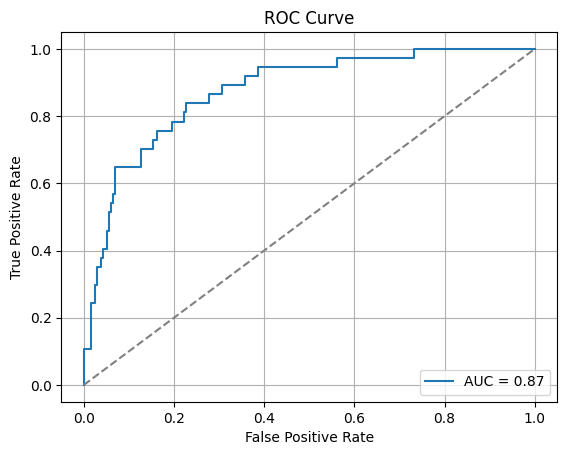

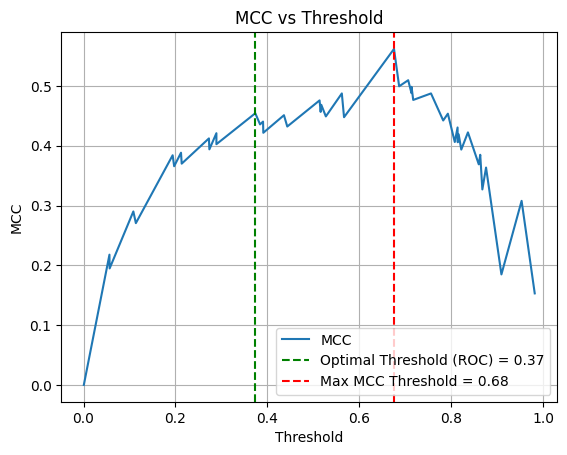

{'model': <Sequential name=sequential, built=True>,
 'scaler': StandardScaler(),
 'auc': 0.8742955721679126,
 'mcc': 0.45434388363824457,
 'log_loss': 0.3811302606878049,
 'history': {'AUC': [0.6284224390983582,
   0.8139619827270508,
   0.7521282434463501,
   0.8066121935844421,
   0.8570825457572937,
   0.8201996088027954,
   0.8243154883384705,
   0.872114360332489,
   0.8469782471656799,
   0.8503655195236206,
   0.8789784908294678,
   0.8833563327789307,
   0.8873763084411621,
   0.8840147256851196,
   0.8972697257995605,
   0.904830276966095,
   0.885088324546814,
   0.9074890613555908,
   0.8926041722297668,
   0.9017179012298584,
   0.886002242565155,
   0.9150112867355347,
   0.90159010887146,
   0.9169861674308777,
   0.904025137424469,
   0.9218754768371582,
   0.9142317175865173,
   0.9115794897079468,
   0.9131643176078796,
   0.918718159198761],
  'Precision': [0.14833760261535645,
   0.22418135404586792,
   0.2054794579744339,
   0.25222551822662354,
   0.278911560773849

In [3]:
neural_networks(df1)
#model_wine(df2)

In [69]:
wine_model = load_model('wine_quality_model.keras')
scaler = joblib.load('scaler.pkl')

In [70]:
sample = df2.drop('quality', axis=1).sample(1, random_state=42)

In [71]:
sample_scaled = scaler.transform(sample)
predicted_quality = wine_model.predict(sample_scaled)

print(f"\nInput data:\n{sample}")
print(f"\nPredicted wine quality (1–10 scale): {predicted_quality[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Input data:
     fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
149            7.2              0.32         0.47             5.1      0.044   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
149                 19.0                  65.0    0.991  3.03       0.41   

     alcohol  
149     12.6  

Predicted wine quality (1–10 scale): 6.87
